In [1]:
# NOT WORKING: need to fix forward (unconditional generation)

In [8]:
import os
import sys
sparse_multiview = f'{os.getcwd()}/../sparse_multiview'
sys.path.append(sparse_multiview)
from multiview import *
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
args = OmegaConf.load(f'{sparse_multiview}/configs/views5.yaml')

['dog']
tensor([[-18.0091,  17.6731]])


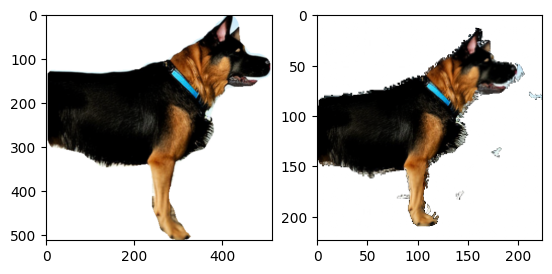

In [10]:
dataset = MultiViewDataset(args)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    #pin_memory=True
)
batch = next(iter(dataloader))
print(batch['class'])
target = batch['target'].squeeze().permute((1, 2, 0))
source = batch['source'].squeeze().permute((1, 2, 0))
print(batch['pose'])
fig, axs = plt.subplots(1, 2)
axs[0].imshow((target+1)/2)
axs[1].imshow((source+1)/2)
plt.show()

In [11]:
model = MultiViewDiffusionModel(args).cuda()
model.eval()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


MultiViewDiffusionModel(
  (multiview_encoder): MultiViewEncoder(
    (model): MaskedAutoencoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
          

In [5]:
batch = {k:v.cuda() if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
images = model.forward(batch)
images

In [6]:
#images

  0%|          | 0/50 [00:00<?, ?it/s]

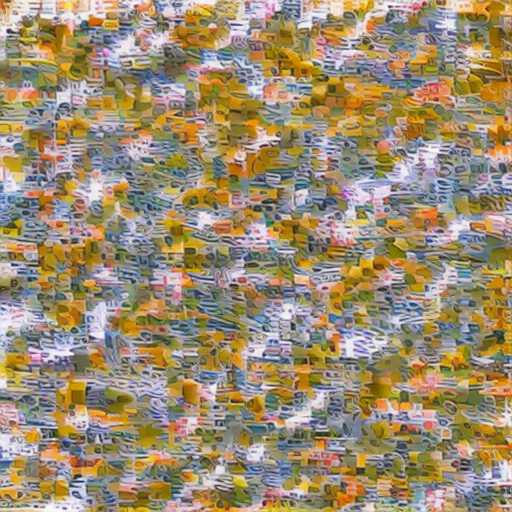

In [13]:
batch = {k:v.cuda() if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
images, attention_maps = model.forward_with_crossattention(batch)
attention_maps = attention_maps.detach().cpu()
orig_image = images
orig_image

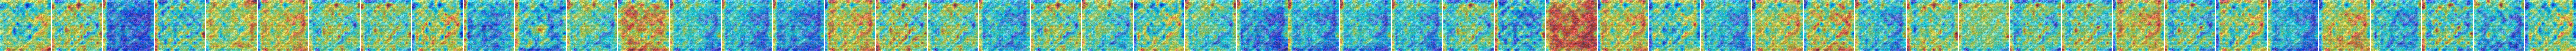

In [25]:
images = []
for i in range(attention_maps.shape[2]):
    image = attention_maps[:, :, i]
    image = show_image_relevance(image, orig_image)
    image = image.astype(np.uint8)
    image = np.array(Image.fromarray(image).resize((res ** 2, res ** 2)))
    images.append(image)
ptp_utils.view_images(np.stack(images, axis=0))
plt.show()

tensor([[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0624, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0624, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0626, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.06

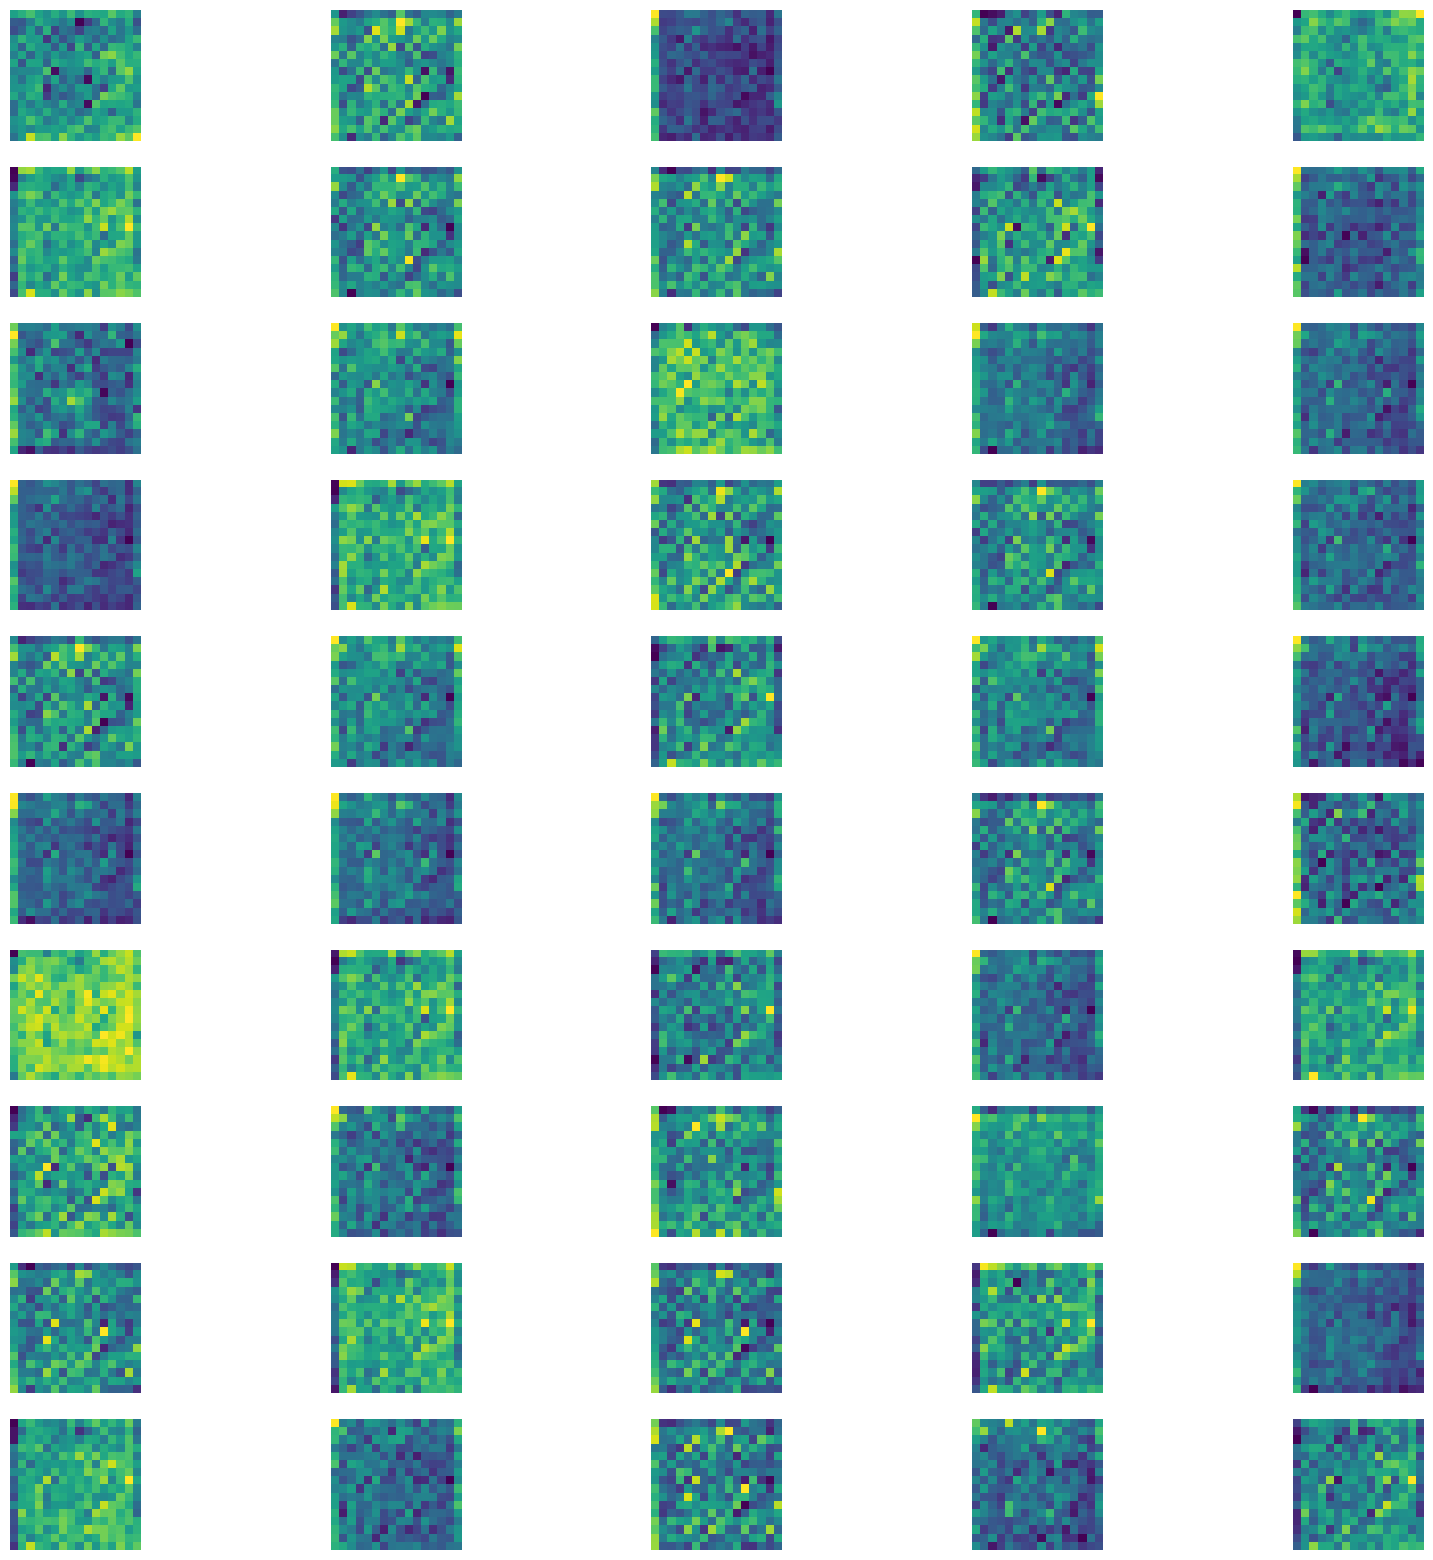

In [22]:
fig, axs = plt.subplots(attention_maps.shape[-1]//5, 5, figsize=(20, 20))
print(attention_maps[:,:,i] / attention_maps[:,:,i].norm())
for i in range(attention_maps.shape[-1]):
    axs[i//5, i%5].imshow(attention_maps[:,:,i] / attention_maps[:,:,i].norm())
    axs[i//5, i%5].set_axis_off()
plt.show()

In [15]:
# Inspired by 
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/notebooks/explain.ipynb
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/utils/vis_utils.py 
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/utils/ptp_utils.py

import ptp_utils
from vis_utils import show_image_relevance
# show spatial attention for indices of tokens to strengthen
n_tokens = attention_maps.shape[2]
res = 16

mae = model.multiview_encoder.model
m = n_tokens // dataset.num_views_per_inst

context = batch['views']
context = context.view(-1, *context.shape[2:])
context_tokens = mae.patchify(context.cuda()).reshape(-1, 768).cpu().numpy()
non_white = np.abs(context_tokens-1).mean(axis=1)
context_tokens = np.array([context_tokens[i] for i in range(len(context_tokens)) if non_white[i] >= 1e-2])

for view in range(dataset.num_views_per_inst):
    images = []
    for i in range(view*m, view*m+m):
        image = attention_maps[:, :, i]
        image = show_image_relevance(image, orig_image)
        image = image.astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((res ** 2, res ** 2)))
        images.append(image)
    ptp_utils.view_images(np.stack(images[1:11], axis=0))
    plt.show()
    
    imgs = context_tokens.reshape(-1, 3, 16, 16).transpose((0,2,3,1))
    #imgs = context_tokens[:10].reshape(-1, 16, 16, 3)
    #print(imgs[0])
    fig, axs = plt.subplots(1, len(imgs))
    for i in range(len(imgs)):
        axs[i].imshow(imgs[i])
        axs[i].set_axis_off()
    plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_96897/1906153966.py:13 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_96897/1906153966.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'MultiViewDataset' object has no attribute 'num_views_per_inst'